In [1]:
import pandas as pd
import pyspark as spark
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from pyspark.ml.linalg import Vectors
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.utils import shuffle
from time_series_service import series_to_supervised
from pyspark.ml.regression import LinearRegression

sc = spark.SparkContext()
sql = spark.SQLContext(sc)

In [2]:
# Read and prepare data to linear regression model

df = pd.read_csv('generated/btc_value_em_tweets_sentimental_score.csv')
df.columns = ['DateTime','Compound','Positive', 'Neutral', 'Negative', 'Price']
df = df[['DateTime','Negative','Neutral','Positive','Compound','Price']]
df = df[['DateTime','Negative','Neutral','Positive','Compound','Price']]
df = df.sort_values('DateTime')
df.set_index('DateTime',inplace=True)

df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 361 entries, 2020-07-01 to 2021-06-26
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Negative  361 non-null    float64
 1   Neutral   361 non-null    float64
 2   Positive  361 non-null    float64
 3   Compound  361 non-null    float64
 4   Price     360 non-null    float64
dtypes: float64(5)
memory usage: 16.9+ KB


,Negative,Neutral,Positive,Compound,Price
DateTime,,,,,
2020-07-01,0.0,0.0,0.0,0.0,144.8
2020-07-02,0.0,0.0,0.0,0.0,18.0
2020-07-03,0.0,0.0,0.0,0.0,-67.3
2020-07-04,0.0,0.0,0.0,0.0,53.4
2020-07-05,0.0,0.0,0.0,0.0,-258.0


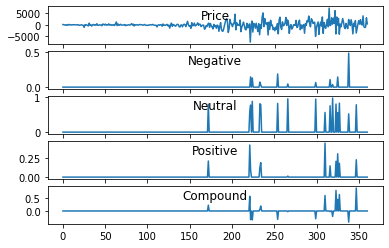

In [3]:
# Plot the time series of all features

columns_groups = [0,1,2,3,4]

cols = df.columns.tolist()
cols = cols[-1:] + cols[:-1]
df = df[cols]

i = 1
plt.figure()
for column_group in columns_groups:
    plt.subplot(len(columns_groups), 1, i)
    plt.plot(df.values[:, column_group])
    plt.title(df.columns[column_group], y=0.5, loc='center')
    i += 1
plt.show()

In [4]:
# Reframe the data so we can apply supervised learning techniques in a time series

n_days = 1
n_features = 5
n_obs = n_days * n_features

scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(df.values)

reframed = series_to_supervised(scaled, n_days, 1)
reframed = reframed.drop(reframed.columns[-4:], axis=1)

cols = reframed.columns.tolist()
cols = cols[-1:] + cols[:-1]
reframed = reframed[cols]

reframed.head()

,var1(t),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1)
1,0.508997,0.517534,0.0,0.0,0.0,0.326643
2,0.503255,0.508997,0.0,0.0,0.0,0.326643
3,0.511381,0.503255,0.0,0.0,0.0,0.326643
4,0.490417,0.511381,0.0,0.0,0.0,0.326643
5,0.513373,0.490417,0.0,0.0,0.0,0.326643


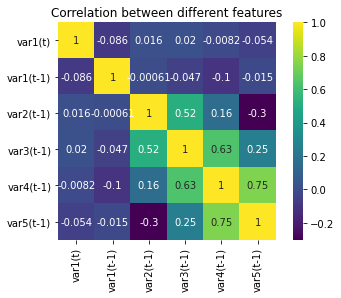

In [5]:
# Plot correlation matrix

correlation = reframed.corr()
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='viridis')
plt.title('Correlation between different features')
plt.show();

In [6]:
# Split train and test data

non_zero_condition = reframed['var5(t-1)'].round(4) != 0.3266

zeros_df = reframed[~non_zero_condition]
non_zeros_df = reframed[non_zero_condition]

zeros_train_size = 0.7
non_zeros_train_size = 0.75

zeros_n_train_days = int(len(zeros_df)*zeros_train_size)
zeros_n_test_days =len(zeros_df) - zeros_n_train_days
non_zeros_n_train_days = int(len(non_zeros_df)*non_zeros_train_size)
non_zeros_n_test_days = len(non_zeros_df) - non_zeros_n_train_days

non_zero_test_step = int(len(non_zeros_df)/non_zeros_n_test_days)
zero_test_step = int(len(zeros_df)/zeros_n_test_days)

non_zero_test = non_zeros_df[::non_zero_test_step]
non_zero_train = pd.merge(non_zeros_df,non_zero_test, indicator=True, how='outer').query('_merge=="left_only"').drop('_merge', axis=1)

zero_test = zeros_df[::zero_test_step]
zero_train = pd.merge(zeros_df,zero_test, indicator=True, how='outer').query('_merge=="left_only"').drop('_merge', axis=1)

train = shuffle(pd.concat((non_zero_train, zero_train)))
test = shuffle(non_zero_test)

In [7]:
# Create and train the linear regression model

reg_DF = sql.createDataFrame(train)
ad_df = reg_DF.rdd.map(lambda x: [Vectors.dense(x[1:]), x[0]]).toDF(['features', 'label'])

lr = LinearRegression(featuresCol = 'features', labelCol = 'label')
lr_model = lr.fit(ad_df)

In [8]:
# Make the predictions and plot the predictions

test_reg_DF = sql.createDataFrame(test)
test_ad_df = test_reg_DF.rdd.map(lambda x: [Vectors.dense(x[1:]), x[0]]).toDF(['features', 'label'])
predictions = lr_model.transform(test_ad_df)

inv_predictions = predictions.rdd.map(lambda x: [x[2],  float(x[0][1]), float(x[0][2]), float(x[0][3]), float(x[0][4])]).toDF(['Price', 'Negative', 'Neutral', 'Positive', 'Compound']).toPandas()
inv_labels = predictions.rdd.map(lambda x: [x[1],  float(x[0][1]), float(x[0][2]), float(x[0][3]), float(x[0][4])]).toDF(['Price', 'Negative', 'Neutral', 'Positive', 'Compound']).toPandas()
inv_predictions = scaler.inverse_transform(inv_predictions)[:,0]
inv_labels = scaler.inverse_transform(inv_labels)[:,0]

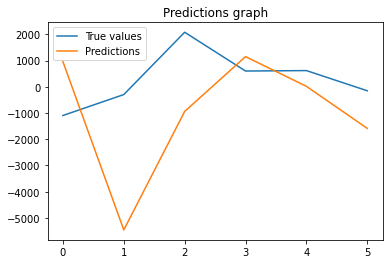

In [9]:
# Plot Results

plt.plot(inv_labels, label="True values")
plt.plot(inv_predictions, label="Predictions")
plt.title("Predictions graph")
plt.legend(loc="upper left")

plt.show()

In [10]:
# Print the results

mse = mean_squared_error(inv_labels, inv_predictions)
r2 = r2_score(inv_labels, inv_predictions)
rmse = np.sqrt(mse)

print("Coefficient of Determination  (R2):", r2)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Square Error: %.3f" % rmse)

Coefficient of Determination  (R2): -6.280342831738116
Mean Squared Error (MSE): 7122231.420040984
Root Mean Square Error: 2668.751


In [11]:
# Save the predictions data to csv file

df_sol = pd.DataFrame({'forecast':inv_predictions,'actual':inv_labels})
df_sol.to_csv('generated/predictions_mv_linear_regression.csv')